In [57]:
from pandas_datareader import data as web
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc

In [2]:
#Grabbing the data from Yahoo-API
start = dt.datetime(2019,1,1)
end = dt.datetime(2019,12,31)

df = web.DataReader("AAPL", "yahoo", start, end)

In [3]:
#Sanity Checks
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,158.850006,154.229996,154.889999,157.919998,37039700.0,154.794983
2019-01-03,145.720001,142.000000,143.979996,142.190002,91312200.0,139.376251
2019-01-04,148.550003,143.800003,144.529999,148.259995,58607100.0,145.326126
2019-01-07,148.830002,145.899994,148.699997,147.929993,54777800.0,145.002686
2019-01-08,151.820007,148.520004,149.559998,150.750000,41025300.0,147.766861


In [4]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-24,284.890015,282.920013,284.690002,284.269989,12119700.0,282.831299
2019-12-26,289.980011,284.700012,284.820007,289.910004,23280300.0,288.442780
2019-12-27,293.970001,288.119995,291.119995,289.799988,36566500.0,288.333313
2019-12-30,292.690002,285.220001,289.459991,291.519989,36028600.0,290.044617
2019-12-31,293.679993,289.519989,289.929993,293.649994,25201400.0,292.163818


In [5]:
df["Close"]["2019-01-03"]

142.19000244140625

In [6]:
df["Close"][1]

142.19000244140625

In [7]:
#Save data as csv
df.to_csv("stock_data.csv", sep=",")

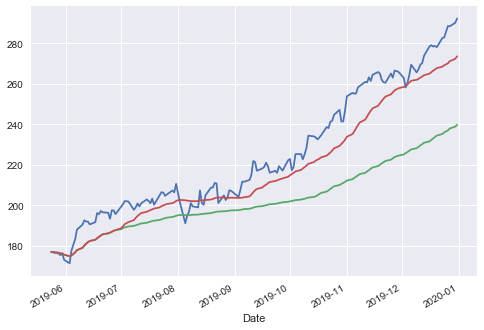

In [10]:
#Data cleaning and crafting SMAs
df.dropna(inplace=True)
df["100ma"] = df["Adj Close"].rolling(window = 100, min_periods = 0).mean()
df["25ma"] = df["Adj Close"].rolling(window = 25, min_periods = 0).mean()

#Plotting
df["Adj Close"].plot()
df["100ma"].plot()
df["25ma"].plot()
style.use("seaborn")
plt.grid(True)
plt.show()

In [11]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,100ma,25ma
Date,,,,,,,,
2019-05-24,182.139999,178.619995,180.199997,178.970001,23714700.0,176.859283,176.859283,176.859283
2019-05-28,180.589996,177.910004,178.919998,178.229996,27948200.0,176.128006,176.493645,176.493645
2019-05-29,179.350006,176.000000,176.419998,177.380005,28481200.0,175.288025,176.091771,176.091771
2019-05-30,179.229996,176.669998,177.949997,178.300003,21218400.0,176.197189,176.118126,176.118126
2019-05-31,177.990005,174.990005,176.229996,175.070007,27043600.0,173.005280,175.495557,175.495557


In [37]:
df["ChangePct"] = ((df["Close"] - df["Open"]) / df["Open"]) * 100

In [46]:
df["ChangePts"] = (df["Close"] - df["Open"])

In [47]:
df["Volatility"] = (df["High"] - df["Low"]) / df["Close"] * 100

In [48]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,100ma,25ma,Change,Volatility,ChangePct,ChangePts
Date,,,,,,,,,,,,
2019-05-24,182.139999,178.619995,180.199997,178.970001,23714700.0,176.859283,176.859283,176.859283,-0.682573,1.966812,-0.682573,-1.229996
2019-05-28,180.589996,177.910004,178.919998,178.229996,27948200.0,176.128006,176.493645,176.493645,-0.385649,1.503671,-0.385649,-0.690002
2019-05-29,179.350006,176.000000,176.419998,177.380005,28481200.0,175.288025,176.091771,176.091771,0.544160,1.888604,0.544160,0.960007
2019-05-30,179.229996,176.669998,177.949997,178.300003,21218400.0,176.197189,176.118126,176.118126,0.196688,1.435781,0.196688,0.350006
2019-05-31,177.990005,174.990005,176.229996,175.070007,27043600.0,173.005280,175.495557,175.495557,-0.658224,1.713600,-0.658224,-1.159988


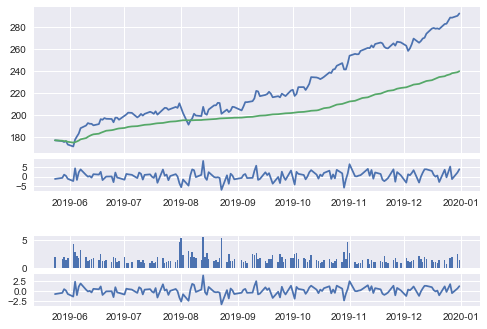

In [55]:
# Adding Subplots
ax1 = plt.subplot2grid((8,1), (0,0), rowspan=4, colspan=1) # window size, start position, plot size (4 x 1)
ax2 = plt.subplot2grid((8,1), (4,0), rowspan=1, colspan=1, sharex=ax1) #...both plots have same axis (1 x 1)
ax3 = plt.subplot2grid((8,1), (6,0), rowspan=1, colspan=1, sharex=ax1) #...both plots have same axis (1 x 1)
ax4 = plt.subplot2grid((8,1), (7,0), rowspan=1, colspan=1, sharex=ax1) #...both plots have same axis (1 x 1)

ax1.plot(df.index, df["Adj Close"])
ax1.plot(df.index, df["100ma"])
ax2.plot(df.index, df["ChangePts"])
ax3.bar(df.index, df["Volatility"])
ax4.plot(df.index, df["ChangePct"])

### Candlestick Charts

In [73]:
df_ohlc = df["Adj Close"].resample("10D").ohlc()

In [64]:
df_ohlc.head()

,open,high,low,close
Date,,,,
2019-05-24,176.859283,176.859283,173.005280,173.005280
2019-06-03,171.256134,192.512451,171.256134,191.899780
2019-06-13,191.860229,197.107620,190.466873,196.435623
2019-06-23,196.237991,200.339050,193.263504,200.339050
2019-07-03,201.999237,201.999237,197.661011,200.902344


In [65]:
df_volume = df["Volume"].resample("10D").sum()

In [66]:
df_volume.head()

Date
2019-05-24    128406100.0
2019-06-03    225723800.0
2019-06-13    172095000.0
2019-06-23    161620400.0
2019-07-03    130228200.0
Freq: 10D, Name: Volume, dtype: float64

In [74]:
df_ohlc.reset_index(inplace=True) #mpl_finance can't work with datetime, therfore: create empty index
df_ohlc["Date"] = df_ohlc["Date"].map(mdates.date2num) # and map each real Date to a numeric Date number

In [77]:
df_ohlc.head()

,Date,open,high,low,close
0,737203.0,176.859283,176.859283,173.005280,173.005280
1,737213.0,171.256134,192.512451,171.256134,191.899780
2,737223.0,191.860229,197.107620,190.466873,196.435623
3,737233.0,196.237991,200.339050,193.263504,200.339050
4,737243.0,201.999237,201.999237,197.661011,200.902344


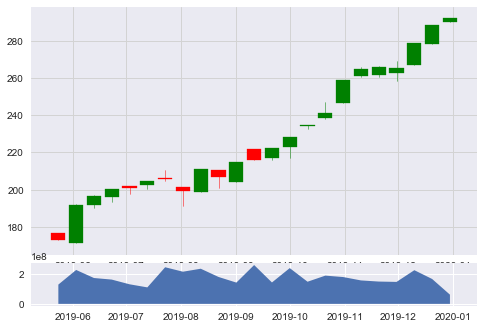

In [89]:
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1) # window size, start position, plot size (5 x 1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1) #...both plots have same axis (1 x 1)
ax1.xaxis_date() # plots date on x-axis 
candlestick_ohlc(ax1, df_ohlc.values, width=8, colorup="g", colordown="r") #creates the candlesticks

ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values)
ax1.grid(True, color="lightgray")
plt.show()